If in Google Colab download and unzip the ChEMBL database.  This takes about 3.5 minutes. 

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !wget https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_mysql.tar.gz
    !gunzip chembl_35_mysql.tar.gz

Load the necessary Python libraries

In [2]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import useful_rdkit_utils as uru
from itertools import combinations
import numpy as np
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem import PandasTools
from molbloom import buy
from tqdm.auto import tqdm
import mols2grid
from molbloom import buy

To begin, we know that the Uniprot ID for hERG is Q12809. To search ChEMBL for compounds tested against hERG, we need to convert that Uniprot ID to a ChEMBL ID. There is a file called `chembl_unitprot_mapping.txt` available on the ChEMBL download site that maps ChEMBL IDs to Uniprot IDs. Let's load that file into a Pandas DataFrame so we can search it.

In [17]:
df = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_uniprot_mapping.txt",sep="\t",
                comment='#',
                names=['uniprot_id','chembl_id','target_name','target_type'])

Now we'll search the dataframe for that Uniprot id. 

In [18]:
df.query("uniprot_id  == 'Q12809' and target_type == 'SINGLE PROTEIN'")

,uniprot_id,chembl_id,target_name,target_type
419,Q12809,CHEMBL240,HERG,SINGLE PROTEIN


Create a connection to the ChEMBL database.  If you're running this notebook locally, change the location of the sqlite database file. 

In [19]:
if IN_COLAB:
    path = "./chembl_35.db"
else:
    path =  "/Users/pwalters/.data/chembl/35/chembl_35/chembl_35_sqlite/chembl_35.db"

In [20]:
conn = sqlite3.connect(path)
cursor = conn.cursor()

Here's the sql query to grab all the hERG data and surrounding information from ChEMBL.  

- **target_dictionary**: Filters targets by chembl_id (CHEMBL240).
- **assays**: Links targets (tid) to assays (assay_id).
- **docs**: Provides document details (doc_id, doi, title).
- **activities**: Connects assays to compound records and provides standard_value and standard_units.
- **compound_records**: Links compound records to molecular structures and provides compound_id.
- **compound_structures**: Extracts canonical_smiles.

In [21]:
sql = """SELECT
    d.doc_id,
    d.doi,
    d.title,
    a.assay_id,
    cr.compound_key,
    cs.molregno,
    cs.canonical_smiles,
    act.standard_type,
    act.standard_value,
    act.standard_relation,
    act.standard_units,
    act.pchembl_value
FROM
    target_dictionary td
        JOIN
    assays a ON td.tid = a.tid
        JOIN
    docs d ON a.doc_id = d.doc_id
        JOIN
    activities act ON a.assay_id = act.assay_id AND d.doc_id = act.doc_id
        JOIN
    compound_records cr ON act.record_id = cr.record_id
        JOIN
    compound_structures cs ON cr.molregno = cs.molregno
WHERE
    td.chembl_id = 'CHEMBL240';"""

Run the query

In [22]:
res = cursor.execute(sql)

Load the results into a Pandas dataframe

In [23]:
df = pd.read_sql_query(sql,conn)
len(df)

30467

In [24]:
import molbloom
molbloom.__version__

'2.3.0'

In [25]:
df.head(5)

,doc_id,doi,title,assay_id,compound_key,molregno,canonical_smiles,standard_type,standard_value,standard_relation,standard_units,pchembl_value
0,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5f,75221,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCN(C(C)C)C...,Ki,1200.0,=,nM,5.92
1,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5i,1595020,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CCCO3)CC2)CC1)...,Ki,730.0,=,nM,6.14
2,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,2,75085,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(c3ccc(F...,Ki,43.0,=,nM,7.37
3,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5b,1595015,CC(C(=O)N[C@]1(c2ccccc2)CC[C@H](N2CCCCC2)CC1)c...,Ki,1200.0,=,nM,5.92
4,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5c,1595019,CC1CCN([C@H]2CC[C@](NC(=O)C(C)c3cc(C(F)(F)F)cc...,Ki,460.0,=,nM,6.34


Only keep compounds with measured values that don't have an operator (>,<) and have standard units in nM (skip entries with %)

In [26]:
df_ok = df.dropna(subset="pchembl_value").query("standard_relation == '='").query("standard_units == 'nM'").copy()
len(df_ok)

11830

In [27]:
df_ok['buy'] = df_ok.canonical_smiles.apply(buy)

In [28]:
df_ok.buy.value_counts()

buy
False    10532
True      1298
Name: count, dtype: int64

In [31]:
df_ok.query("buy")[["canonical_smiles","molregno"]].to_csv("molbloom_test.csv",index=False)

In [12]:
tqdm.pandas()

Calculate fingerprints 

In [13]:
smi2fp = uru.Smi2Fp()
df_ok['fp'] = df_ok.canonical_smiles.progress_apply(smi2fp.get_fp)

  0%|          | 0/11830 [00:00<?, ?it/s]

A function to process the structures from a paper and identify interesting pairs of compounds where the hERG activity differs by at least 10-fold. The logic here is as follows.  
1. Group the data by **assay id** and **result type** (IC50 or Ki)
2. Loop over pairs of compounds
3. Select pairs where the difference in activity is at least 10-fold
4. Calculate the Tanimoto similarity between pairs
5. Store the pair 

In [14]:
def get_series_from_paper(input_df):
    res = []
    for k,v in input_df.groupby(["assay_id","standard_type","standard_units"]):
        paper_df = v.copy()
        paper_df['mol'] = paper_df.canonical_smiles.apply(Chem.MolFromSmiles)
        activity_df = paper_df[['doc_id','canonical_smiles','molregno','compound_key','standard_value','assay_id','standard_type','standard_units','pchembl_value']]
        mol_df, scaffold_df = uru.find_scaffolds(paper_df,smiles_col="canonical_smiles",name_col="molregno", disable_progress=True)
        scaffold_smi, out_df = uru.get_molecules_with_scaffold(scaffold_df.Scaffold.values[0], mol_df, activity_df,
                                  smiles_col="canonical_smiles", 
                                  name_col="molregno",
                                  activity_col="standard_value",
                                  extra_cols=["compound_key","assay_id","standard_type","standard_units","doc_id","pchembl_value"])
        out_df.merge(paper_df[["canonical_smiles","molregno","compound_key"]],on=["canonical_smiles","molregno"])
        if len(out_df) > 1:
            res.append([scaffold_smi,out_df])
    return res

In [18]:
test_df = df_ok.query("doc_id == 117736")
test_res = get_series_from_paper(z_df)
test_res

[[array(['CC(C)n1cc(C(=O)c2cncc(NC(=O)C[*:3])c2)c2c([*:1])nc([*:2])nc21'],
        dtype=object),
                                      canonical_smiles  molregno  \
  0  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(Cl)cc3)c2)c...   2526613   
  1  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(Cl)cc3)c2)c...   1994374   
  2  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(C#N)cc3)c2)...   1994376   
  3  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(C#N)cc3)c2)...   2531494   
  4  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cn3ccc(C4CC4)n3)c2...   1994395   
  5  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cn3ccc(C4CC4)n3)c2...   1999216   
  6  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(Cl)cc3)c2)c...   1999213   
  
     standard_value compound_key  assay_id standard_type standard_units  doc_id  \
  0         10800.0            3   2027231            Ki             nM  117736   
  1          5200.0            4   2027231            Ki             nM  117736   
  2          7100.0            5   2027231            Ki             nM  117736   
  3          9700.0    

In [19]:
df_list = []
for k,v in tqdm(df_ok.groupby("doc_id")):
    if len(v) > 2:
        series_res = get_series_from_paper(v)
        for scaffold_smi, paper_df in series_res:
            if len(scaffold_smi):
                paper_df['doi'] = v.doi.values[0]
                paper_df['scaffold'] = scaffold_smi[0]
                paper_df.drop_duplicates(["canonical_smiles","molregno"],inplace=True)
                df_list.append(paper_df)

  0%|          | 0/1576 [00:00<?, ?it/s]

In [20]:
pd.concat(df_list).to_csv("chembl_hERG_summary.csv",index=False)

In [21]:
def align_mols_to_template(template_smiles, smiles_list):
    # remove dummy atoms
    scaffold_mol = Chem.RWMol(Chem.MolFromSmiles(template_smiles))
    remove_list = []
    for atm in scaffold_mol.GetAtoms():
        if atm.GetAtomicNum() == 0:
            remove_list.append(atm.GetIdx())
    remove_list.sort(reverse=True)
    for atm_id in remove_list:
        scaffold_mol.RemoveAtom(atm_id)
    Chem.SanitizeMol(scaffold_mol)
    scaffold_mol = Chem.Mol(scaffold_mol)
    # generate coordinates for the template
    AllChem.Compute2DCoords(scaffold_mol)
    # generate RDKit molecules for the input structures
    mol_list = [Chem.MolFromSmiles(x) for x in tmp_df.canonical_smiles]
    # generate aligned structures
    aligned_mol_list = [AllChem.GenerateDepictionMatching2DStructure(m,scaffold_mol) for m in mol_list]
    return mol_list

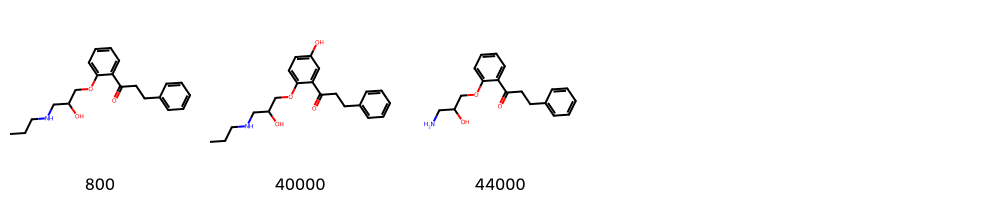

In [22]:
tmp_df = df_list[12].copy()
tmp_df.sort_values("standard_value",inplace=True)
legends = [f"{x:.0f}" for x in tmp_df.standard_value]
Chem.Draw.MolsToGridImage(align_mols_to_template(tmp_df.scaffold.values[0],tmp_df.canonical_smiles),molsPerRow=5,useSVG=True,legends=legends)

In [23]:
combo_df = pd.concat(df_list)
combo_df.doc_id.value_counts()

doc_id
91690    56
58848    56
93121    52
98610    51
51341    41
         ..
99303     2
62935     2
62981     2
65350     2
57429     2
Name: count, Length: 760, dtype: int64

In [24]:
combo_df['purchasable'] = combo_df.canonical_smiles.apply(buy)

In [55]:
result_list = []
for k,v in combo_df.query("purchasable").groupby(["doc_id","scaffold"]):
    doc_id,scaffold = k
    if len(v) > 1:
        min_val = v.standard_value.min()
        max_val = v.standard_value.max()
        range_val = abs(np.log10(min_val) - np.log10(max_val))
        result_list.append([doc_id,scaffold,len(v),min_val,max_val,range_val])
pd.DataFrame(result_list,columns=["doc_id","scaffold","num","min_val","max_val","range"]).query("range >= 1").sort_values("range",ascending=False).round(1)

,doc_id,scaffold,num,min_val,max_val,range
13,51887,O=C(NC(=S)Nc1cc([*:2])cc([*:3])c1[*:4])c1ccc([...,5,10.0,4720.0,2.7
0,5535,c1cc([*:3])ccc1-n1cc(C2CCN([*:2])CC2)c2cc([*:1...,2,3.0,204.0,1.8
2,20904,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,2,0.9,28.2,1.5
1,5706,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,3,1.0,28.2,1.4
3,42094,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,3,1.0,28.2,1.4
8,46532,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,2,1.0,27.5,1.4
35,126186,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],10,539.6,10999.9,1.3
14,55596,c1cc([*:3])ccc1-n1cc(C2CCN([*:2])CC2)c2cc([*:1...,2,14.8,204.2,1.1
5,44897,CN(C(c1cc([*:4])c([*:3])cc1Oc1ccc([*:1])c([*:2...,11,645.0,8290.0,1.1


In [84]:
doc_id = 126186

In [85]:
combo_df.query("doc_id == @doc_id and purchasable").sort_values("standard_value")

,canonical_smiles,molregno,standard_value,compound_key,assay_id,standard_type,standard_units,doc_id,pchembl_value,doi,scaffold,purchasable
3,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21,6216,539.6,chlorpromazine,2305008,AC50,nM,126186,6.27,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
11,CN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1,1325,749.0,trifluoperazine,2305008,AC50,nM,126186,6.13,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
5,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,16505,900.0,perphenazine,2305008,AC50,nM,126186,6.05,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
12,CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,37266,994.0,prochlorperazine,2305008,AC50,nM,126186,6.00,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
13,CCSc1ccc2c(c1)N(CCCN1CCN(C)CC1)c1ccccc1S2,320810,1200.0,thiethylperazine,2305008,AC50,nM,126186,5.92,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
7,CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2,57294,2500.0,acepromazine,2305008,AC50,nM,126186,5.60,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
2,CN(C)CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21,16584,3500.0,triflupromazine,2305008,AC50,nM,126186,5.46,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
0,N#Cc1ccc2c(c1)N(CCCN1CCC(O)CC1)c1ccccc1S2,418410,5820.0,periciazine,2305008,AC50,nM,126186,5.24,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
1,CN(C)CCCN1c2ccccc2Sc2ccccc21,16391,8100.1,promazine,2305008,AC50,nM,126186,5.09,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True
9,COc1ccc2c(c1)N(C[C@H](C)CN(C)C)c1ccccc1S2,583530,10999.9,levomepromazine,2305008,AC50,nM,126186,4.96,10.1038/s41467-023-40064-9,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],True


In [86]:
mols2grid.display(combo_df.query("doc_id == @doc_id and purchasable"),smiles_col="canonical_smiles",size=(200,200),
                 subset=["img","standard_value"],sort_by="standard_value")

MolGridWidget()

In [119]:
df_list[350]

,canonical_smiles,molregno,standard_value,compound_key,assay_id,standard_type,standard_units,doc_id,doi,scaffold
0,NCC(=O)N1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([N+...,1727281,18300.0,7,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
1,C[C@H](N)C(=O)N1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4c...,1727282,1280.0,8,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
2,C[C@@H](N)C(=O)N1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4...,1727283,4920.0,9,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
3,CCNC(=O)N1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([N...,1727514,210.0,13,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
4,CCCNC(=O)N1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([...,1727515,1280.0,14,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
5,CN1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([N+](=O)[...,1141562,49.0,1,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
6,CC(=O)N1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([N+]...,1141563,460.0,2,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
7,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc(N4CC...,1727517,37.0,3,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
8,[2H]C(Nc1cc(C(F)(F)F)cc2ncc(N3CCN(C)CC3)cc12)c...,1727538,1270.0,38,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...
9,[2H]C([2H])(O)CN1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4...,1727540,160.0,40,1327499,IC50,nM,81950,10.1039/C2MD20192E,O=[N+]([O-])c1cccc(CNc2cc(C(F)(F)F)cc3ncc([*:1...


In [111]:
herg_combo_df = pd.concat(df_list)

In [115]:
df_list[0]

,canonical_smiles,molregno,standard_value,compound_key,assay_id,standard_type,standard_units,doc_id,doi,scaffold
0,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCN(C(C)C)C...,75221,1200.0,5f,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
1,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CCCO3)CC2)CC1)...,1595020,730.0,5i,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
2,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(c3ccc(F...,75085,43.0,2,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
3,CC(C(=O)N[C@]1(c2ccccc2)CC[C@H](N2CCCCC2)CC1)c...,1595015,1200.0,5b,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
4,CC1CCN([C@H]2CC[C@](NC(=O)C(C)c3cc(C(F)(F)F)cc...,1595019,460.0,5c,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
5,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(=O)CC2)...,75985,4000.0,5g,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
6,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC3(CC2)OC...,75496,1000.0,5h,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
7,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(O)CC2)C...,75764,1400.0,5e,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
8,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CC2)CCC(C)(C)O...,1595023,950.0,5m,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...
9,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC(O)(Cc3ccccc3)CC...,1595021,260.0,5d,220871,Ki,nM,4905,10.1016/s0960-894x(02)00250-0,CC(C(=O)NC1(c2ccccc2)CCC([*:1])CC1)c1cc(C(F)(F...


In [34]:
herg_combo_df = pd.concat(df_list)
herg_combo_df.doi.value_counts()

doi
10.1016/j.bmc.2016.02.031       51
10.1016/j.bmcl.2015.06.061      50
10.1016/j.bmcl.2015.04.002      49
10.1016/j.bmcl.2011.07.006      41
10.1016/j.bmcl.2010.04.045      41
                                ..
10.1016/j.bmcl.2006.11.061       1
10.1021/acs.jmedchem.8b01533     1
10.1016/j.bmcl.2007.05.087       1
10.1016/j.vascn.2014.07.002      1
10.1016/j.bmcl.2011.02.067       1
Name: count, Length: 513, dtype: int64

In [17]:
def mcs_align(smiles_list):
    # convert the SMILES to RDKit molecules
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    # define the parameters for the MCS calculation, if we're aligning it's import that the MCS only contains complete rings
    params = Chem.rdFMCS.MCSParameters()
    params.BondCompareParameters.CompleteRingsOnly=True
    params.AtomCompareParameters.CompleteRingsOnly=True
    # find the MCS
    mcs = FindMCS(mol_list,params)
    # get query molecule from the MCS, we will use this as a template for alignment
    qmol = mcs.queryMol
    # generate coordinates for the template
    AllChem.Compute2DCoords(qmol)
    # generate coordinates for the molecules using the template
    [AllChem.GenerateDepictionMatching2DStructure(m,qmol) for m in mol_list]
    # Draw the molecules, highlighting the MCS
    return mol_list

In [ ]:
smi_list = herg_combo_df.query("doi == '10.1016/j.bmcl.2015.06.061'").sort_values("standard_value").canonical_smiles.values
mcs_align(smi_list[:10])

In [ ]:
tmp_df = herg_combo_df.query("doi == '10.1016/j.bmcl.2015.06.061'").sort_values("standard_value")
tmp_df['mol'] = mcs_align(tmp_df.canonical_smiles)

In [57]:
mols2grid.display(tmp_df,mol_col="mol",size=(200,200),
                 subset=["img","standard_value"],use_coords=True,prerender=True)

MolGridWidget()

In [15]:
v = v.copy()
v['mol'] = v.canonical_smiles.apply(Chem.MolFromSmiles)

In [16]:
activity_df = v[['canonical_smiles','molregno','standard_value']]

In [17]:
mol_df, scaffold_df = uru.find_scaffolds(v,smiles_col="canonical_smiles",name_col="molregno")

  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
scaffold_smi, out_df = uru.get_molecules_with_scaffold(scaffold_df.Scaffold.values[0], mol_df, activity_df,
                              smiles_col="canonical_smiles", 
                              name_col="molregno",
                              activity_col="standard_value")

In [19]:
out_df.sort_values("standard_value")

,canonical_smiles,molregno,standard_value
2,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(c3ccc(F...,75085,43.0
9,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC(O)(Cc3ccccc3)CC...,1595021,260.0
13,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC(C3CCC(=O)O3)CC2...,1595017,400.0
4,CC1CCN([C@H]2CC[C@](NC(=O)C(C)c3cc(C(F)(F)F)cc...,1595019,460.0
11,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC(C3CCOC3=O)CC2)C...,1595024,490.0
10,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CCOC3)CC2)CC1)...,1595018,710.0
1,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CCCO3)CC2)CC1)...,1595020,730.0
8,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CC2)CCC(C)(C)O...,1595023,950.0
6,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC3(CC2)OC...,75496,1000.0
0,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCN(C(C)C)C...,75221,1200.0


In [24]:
def process_paper(paper_df):
    res = []
    for k,v in paper_df.groupby(["assay_id","standard_type"]):
        for a,b in combinations(list(v.iterrows()),2):
            idx_a, vals_a = a
            idx_b, vals_b = b
            delta = np.abs(vals_a.pchembl_value-vals_b.pchembl_value)
            if delta > 1:
                if vals_a.standard_value > vals_b.standard_value:
                    vals_a, vals_b = vals_b, vals_a
                tc = DataStructs.TanimotoSimilarity(vals_a.fp,vals_b.fp)
                res.append([vals_a.doc_id, vals_a.doi,
                      delta,tc,vals_a.standard_type,
                      vals_a.canonical_smiles,vals_b.canonical_smiles,
                      vals_a.compound_key, vals_b.compound_key,
                      vals_a.standard_value,vals_b.standard_value])
    cols = ["doc_id", "doi", "delta", "tanimoto","standard_type","smiles_a","smiles_b","key_a","key_b","val_a","val_b"]
    res_df = pd.DataFrame(res, columns=cols)
    return res_df

Process papers one at a time.  Each call to `process_paper` returns a dataframe with "interesting" pairs. In the cell below, we build up a list of these dataframes.  

In [25]:
df_list = []
for k,v in tqdm(df_ok.groupby("doc_id")):
    res_df = process_paper(v)
    if len(res_df):
        df_list.append(res_df)

  0%|          | 0/1576 [00:00<?, ?it/s]

Concatenate the list of dataframes from the cell above into a single dataframe. 

In [26]:
combo_df = pd.concat(df_list)

See how many papers contained interesting pairs

In [27]:
len(df_list)

532

See how many structure pairs we extracted. 

In [28]:
len(combo_df)

69800

Create a new dataframe with only IC50 and Ki data.

In [29]:
ic50_ki_df = combo_df.query("standard_type in ['IC50','Ki']").copy()

How many documents are left? 

In [30]:
len(ic50_ki_df.doc_id.unique())

526

Use [Andrew White's molbloom filter](https://github.com/whitead/molbloom) to determine whether compounds are commercially available. 

In [31]:
ic50_ki_df['buy_a'] = ic50_ki_df.smiles_a.apply(buy)
ic50_ki_df['buy_b'] = ic50_ki_df.smiles_b.apply(buy)

Create a new dataframe containing pairs where both molecules are commercially available. 

In [32]:
buy_df = ic50_ki_df.query("buy_a and buy_b and tanimoto >= 0.5").copy()

In [33]:
PandasTools.AddMoleculeColumnToFrame(buy_df,smilesCol="smiles_a",molCol="mol_a")
PandasTools.AddMoleculeColumnToFrame(buy_df,smilesCol="smiles_b",molCol="mol_b")

In [34]:
def make_clickable_url(val):
    val = "https://doi.org/"+val
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [35]:
def mcs_align_mol_pair(mol1, mol2):
    params = Chem.rdFMCS.MCSParameters()
    params.BondCompareParameters.CompleteRingsOnly=True
    params.AtomCompareParameters.CompleteRingsOnly=True
    # find the MCS
    mcs = FindMCS([mol1,mol2],params)
    # get query molecule from the MCS, we will use this as a template for alignment
    qmol = mcs.queryMol
    # generate coordinates for the template
    AllChem.Compute2DCoords(qmol)
    # generate coordinates for the molecules using the template
    [AllChem.GenerateDepictionMatching2DStructure(m,qmol) for m in [mol1,mol2]]

In [40]:
for a,b in tqdm(buy_df[["mol_a","mol_b"]].values):
    mcs_align_mol_pair(a,b)

  0%|          | 0/22 [00:00<?, ?it/s]

Scroll right to see the chemical structures

,doc_id,doi,delta,tanimoto,standard_type,smiles_a,smiles_b,key_a,key_b,val_a,val_b,buy_a,buy_b,mol_a,mol_b
236,5535,10.1016/s0960-894x(03)00196-3,1.83,0.583333,IC50,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,Fc1ccc(-n2cc(C3CCNCC3)c3cc(Cl)ccc32)cc1,Sertindole,14,3.000,204.00,True,True,,
169,5706,10.1016/s0960-894x(03)00492-x,1.45,0.602273,IC50,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,Desmetheylastemizole,Norastemizole,1.000,28.18,True,True,,
646,5706,10.1016/s0960-894x(03)00492-x,1.14,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,Clozapine,Norclozapine,323.590,4466.84,True,True,,
23,20904,10.1016/j.bmcl.2005.01.008,1.49,0.582418,IC50,COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2...,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,Astemizole,Norastemizole,0.912,28.18,True,True,,
88,42094,10.1016/j.bmc.2008.04.028,1.45,0.602273,IC50,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,"58, Desmethylastemizole","65, Norastemizole",1.000,28.18,True,True,,
635,42094,10.1016/j.bmc.2008.04.028,1.14,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,14,"41, Norclozapine",323.590,4466.84,True,True,,
31,44897,10.1016/j.bmcl.2008.10.028,1.06,0.517241,IC50,CNCc1ccc(Cl)cc1Oc1ccc(Cl)cc1,CNCc1cc(F)ccc1Oc1ccc(Cl)cc1,54,24,645.000,7390.00,True,True,,
7,46532,10.1016/j.ejmech.2007.12.025,1.44,0.602273,IC50,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,Desmethylastemizole,Norastemizole,1.000,27.54,True,True,,
465,46990,10.1021/jm900002x,1.15,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,Clozapine,N-desmethyl-Clozapine,320.000,4490.00,True,True,,
501,46990,10.1021/jm900002x,1.15,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,Clozapine,N-desmethyl-Clozapine,320.000,4490.00,True,True,,

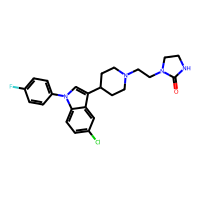
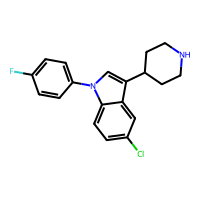
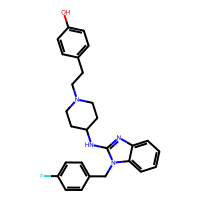
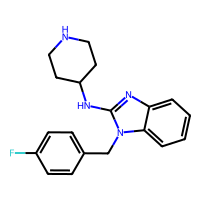
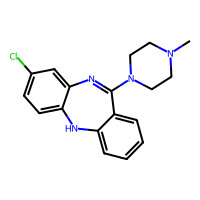
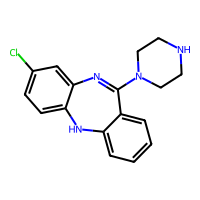
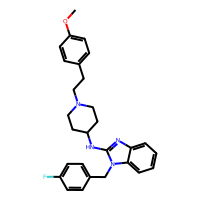
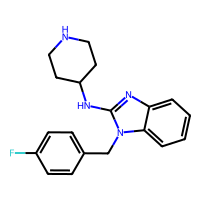
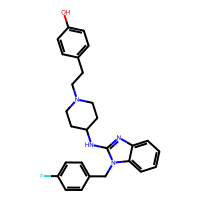
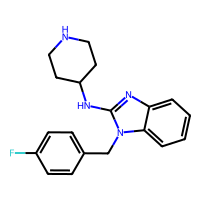
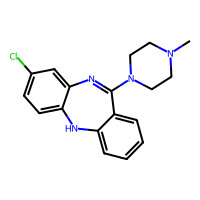
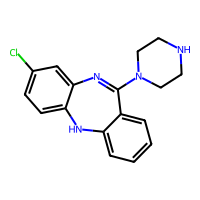
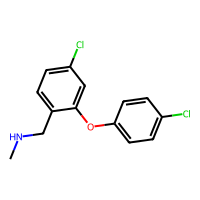
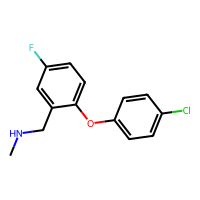
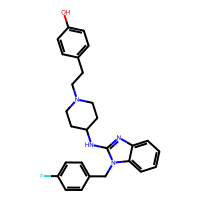
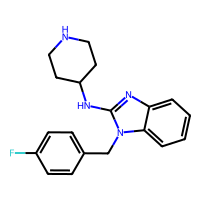
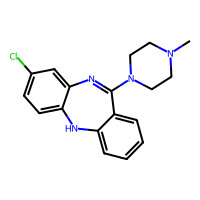
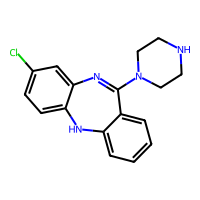
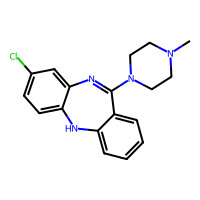
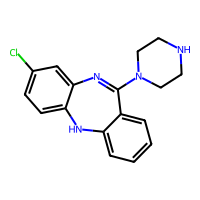
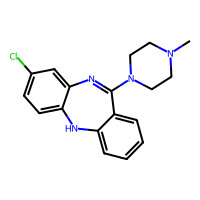
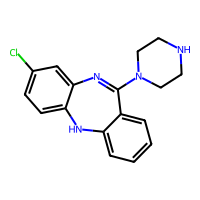
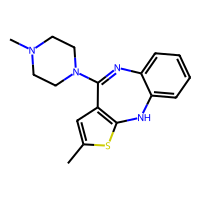
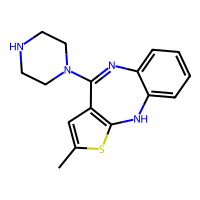
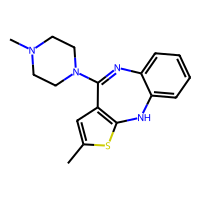
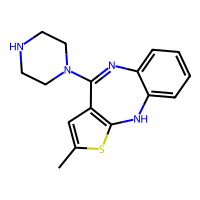
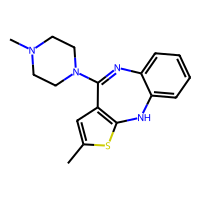
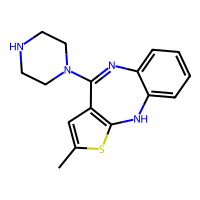
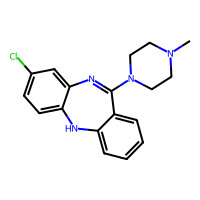
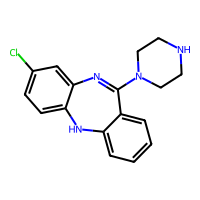
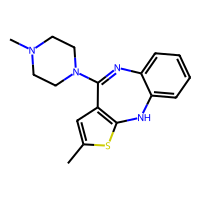
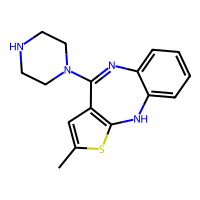
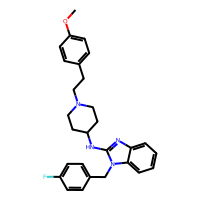
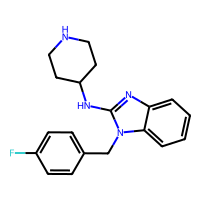
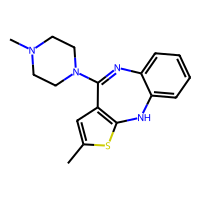
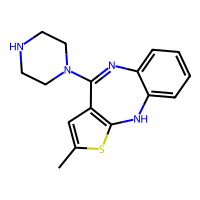
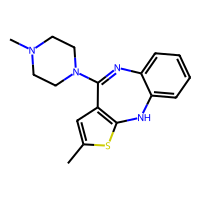
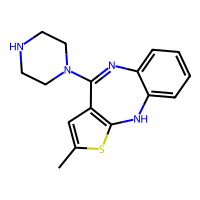
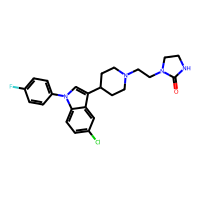
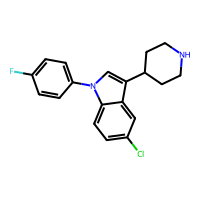
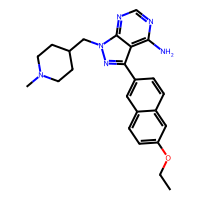
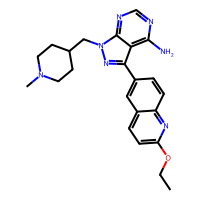
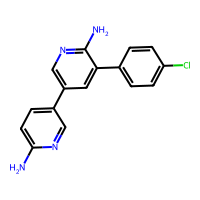
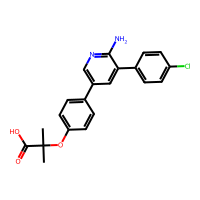

In [41]:
buy_df